# Data Analysis & Anxiety Prediction
-------------------
### Workflow:
##### 1. import preprocessed data from 5 labelled events
##### 2. basic visualisations and analysis of data
##### 3. normalise and split data in train and test data
##### 4. train predictive models using 7 classification algorithms
##### 5. evaluate models with 7-fold cross validation and confusion matrics

---------------------


##### 0. Import packages

In [2]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import signal 
import seaborn as sns

##### 1. Import labelled data : collected during events such as pitchs, interview and meetings

In [4]:
# 0 = HR (BPM), 1 = EDA, 2 = Anxiety/Stress labels

df1 = pd.read_csv("Event1/combined_data_cleaned_1.csv")
df2 = pd.read_csv("Event2/combined_data_cleaned_1.csv")
df3 = pd.read_csv("Event3/combined_data_cleaned_1.csv")
df4 = pd.read_csv("Event4/combined_data_cleaned_1.csv")
df5 = pd.read_csv("Event5/combined_data_cleaned_1.csv")

result = pd.concat([df1,df2,df3,df4,df5], axis=0, join='outer', ignore_index=False)
resultsdf = result.drop('Unnamed: 0', axis =1)
resultsdf = resultsdf.reset_index(drop=True)

resultsdf.to_csv("connected_data_cleaned_1.csv")
display(resultsdf.head(5))
resultsdf.shape

,0,1,2
0,76.71,0.218787,0.0
1,76.74,0.218147,0.0
2,76.77,0.218467,0.0
3,76.81,0.218467,0.0
4,76.85,0.219108,0.0


(225181, 3)

##### 2. Visualisation and basic analysis :  3 separate time series plots, distribution of anxiety labels, normalise data, combined plot, and correlation matrix

Text(0, 0.5, ' stress labels')

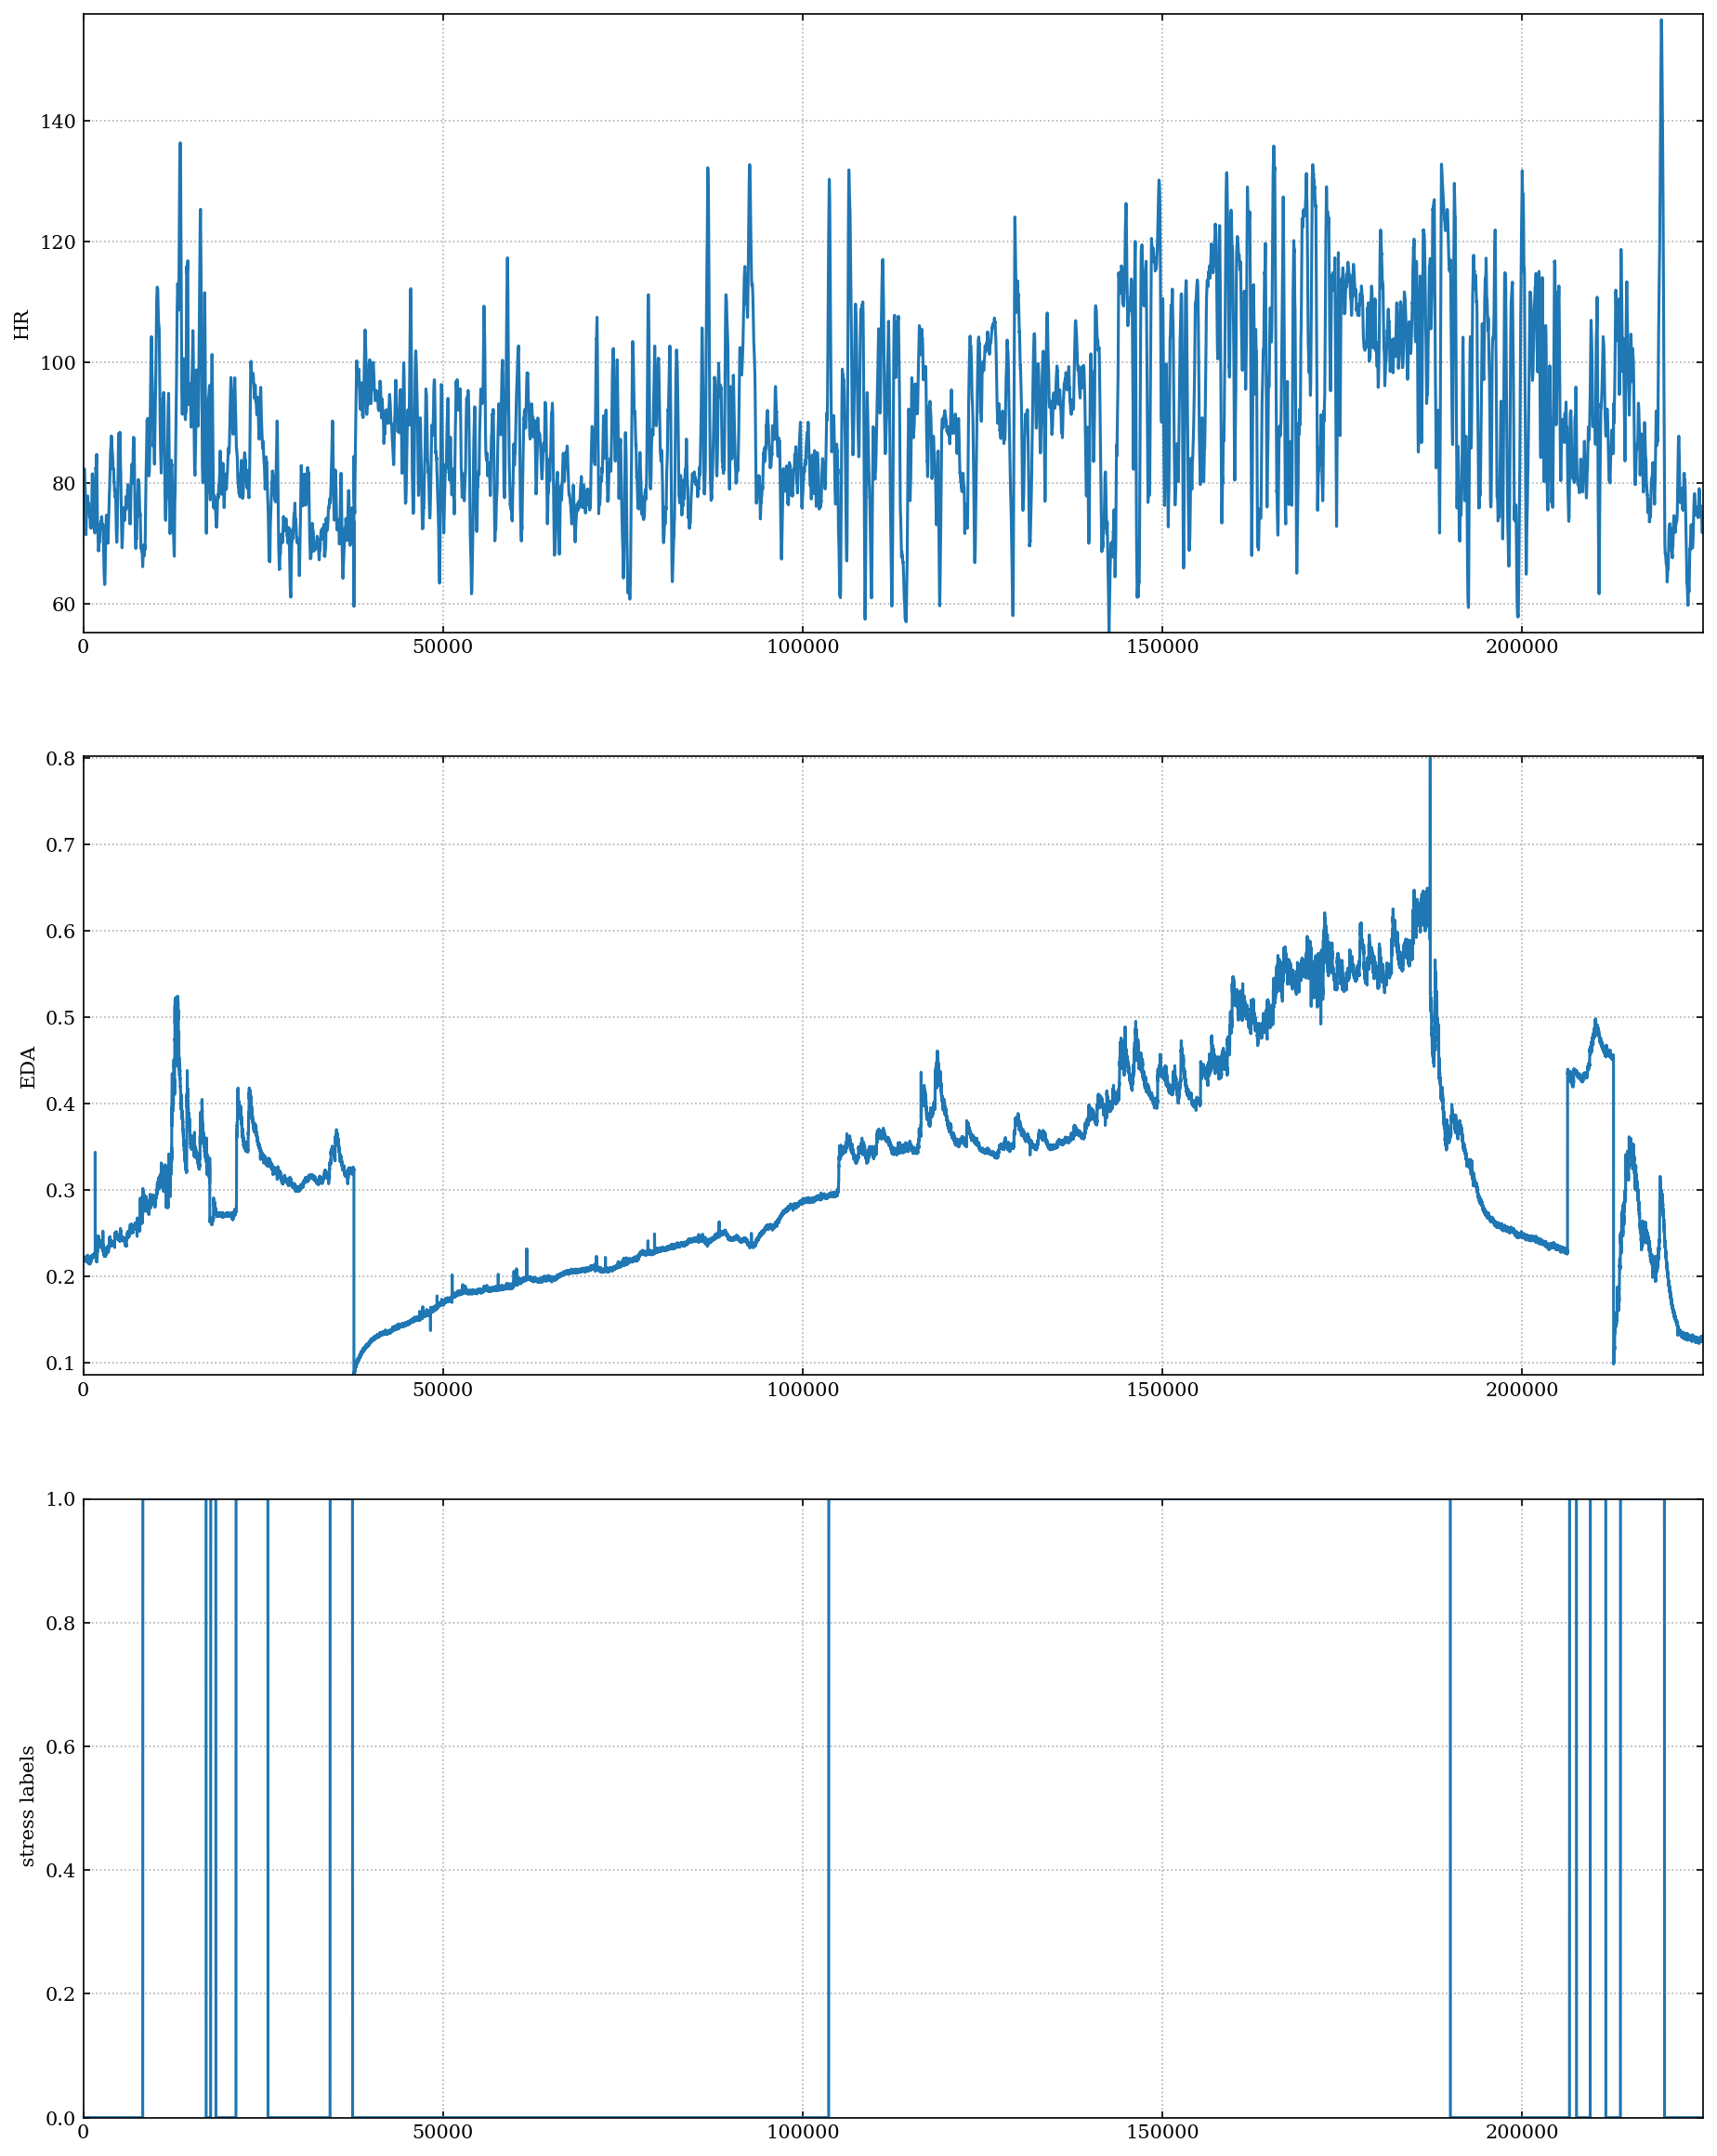

In [5]:
#Time series plot of 3 types of data

plt.rcParams["font.family"] = "serif"
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.dpi"] = 150
plt.rcParams['figure.figsize'] = 20, 10

def newfigure(*args, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    for i, a in enumerate(fig.axes):
        a.tick_params(direction='in', grid_linestyle=":", top=True, right=True)
        a.grid(which='major', axis='both', linestyle=":")
    return fig, ax

fig, ax = newfigure(3, figsize=(15,20))


ax[0].set_xlim(0,225181)
ax[0].set_ylim(resultsdf['0'].min(), resultsdf['0'].max() + 1)
ax[1].set_xlim(0,225181)
ax[1].set_ylim(resultsdf['1'].min() , resultsdf['1'].max() +0.002)
ax[2].set_xlim(0,225181)
ax[2].set_ylim(resultsdf['2'].min(), resultsdf['2'].max() )

ax[0].plot(resultsdf['0'])
ax[0].set_ylabel("HR")
ax[1].plot(resultsdf['1'])
ax[1].set_ylabel("EDA")
ax[2].plot(resultsdf['2'])
ax[2].set_ylabel(" stress labels")

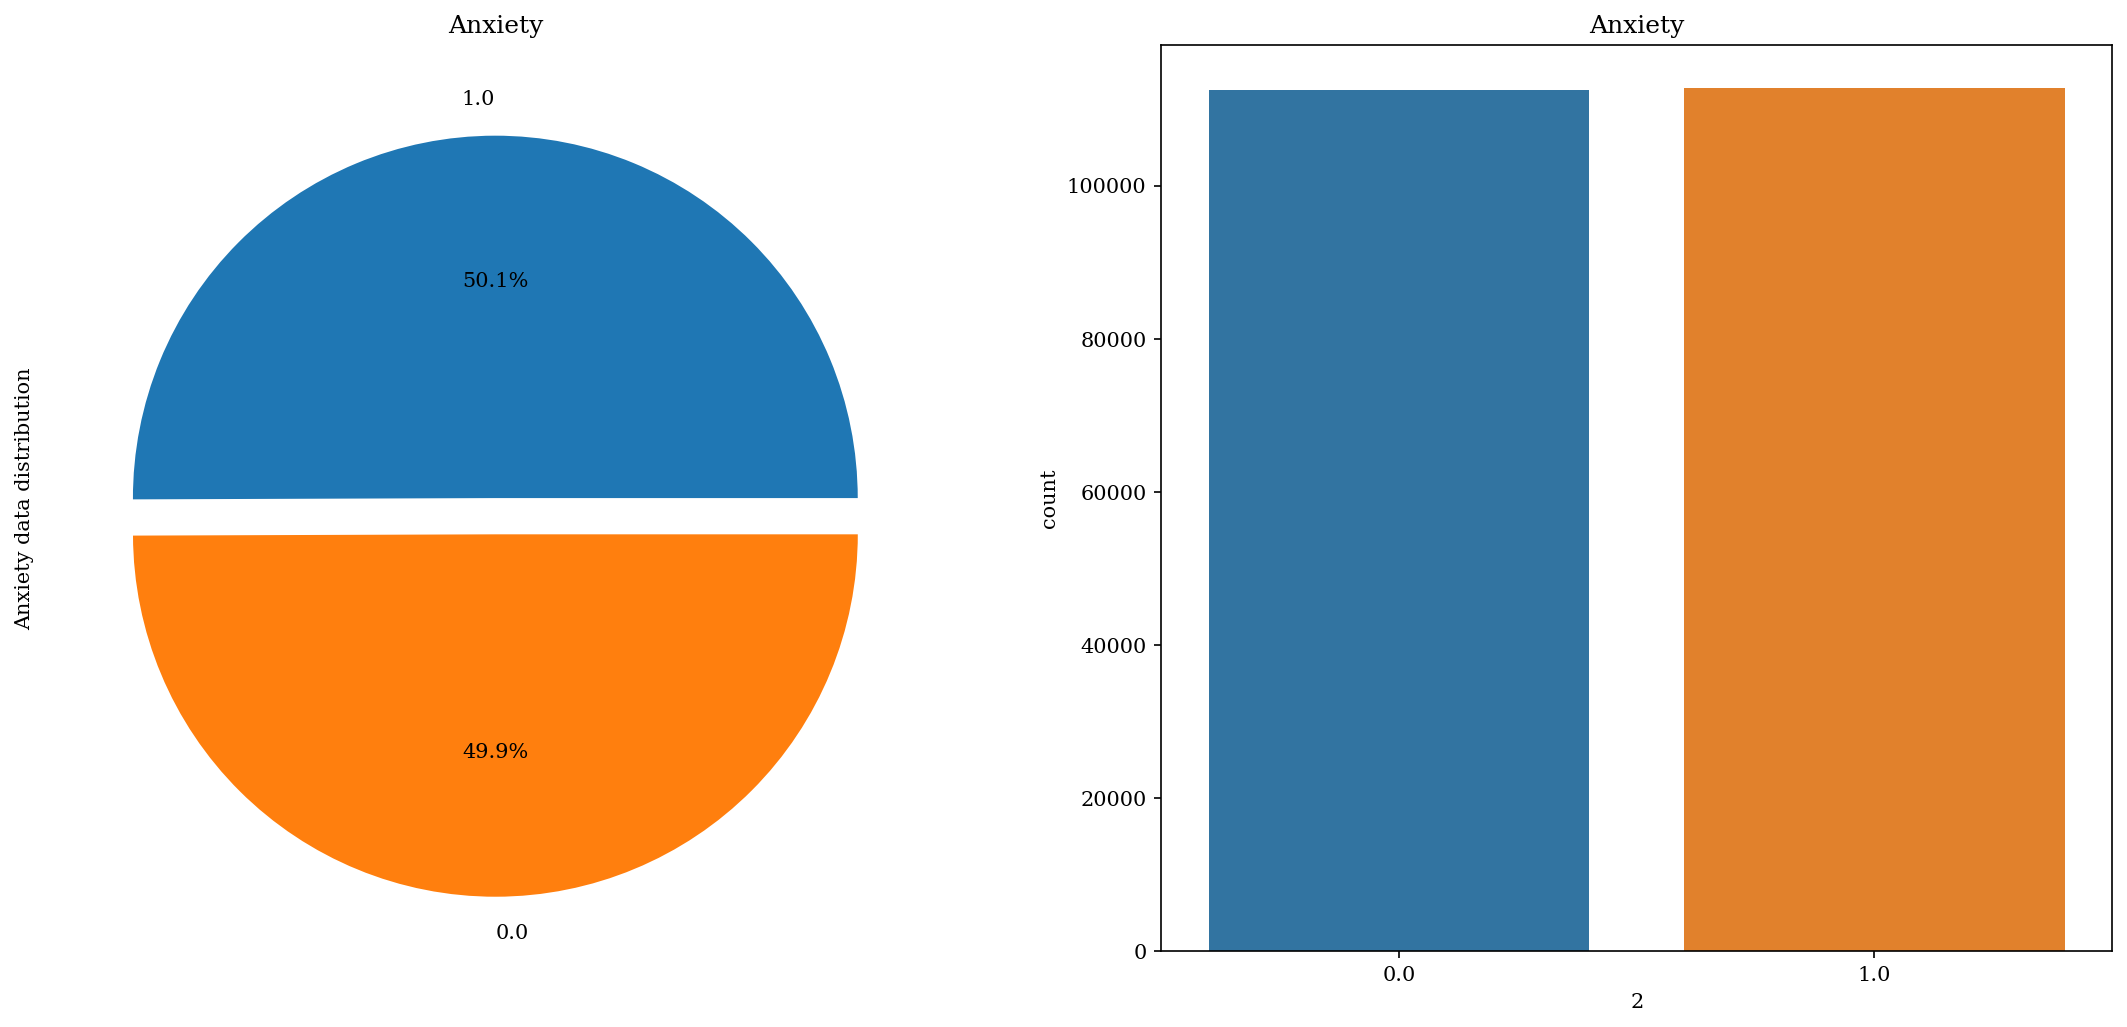

In [6]:
#Distribution of anxiety labels

f,ax=plt.subplots(1,2,figsize=(18,8))
resultsdf['2'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=False)
ax[0].set_title('Anxiety')
ax[0].set_ylabel('Anxiety data distribution')
sns.countplot('2',data=resultsdf,ax=ax[1])
ax[1].set_title('Anxiety')
plt.show()

In [5]:
#Normalise data

ndata = resultsdf.copy(deep=True)

stats = {}

for name in ndata.columns.values:
    mean = np.mean(ndata[name])
    stdv = np.std(ndata[name])
    ndata[name] = (ndata[name] - mean) / stdv


C:\Users\Ruksana\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Ruksana\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


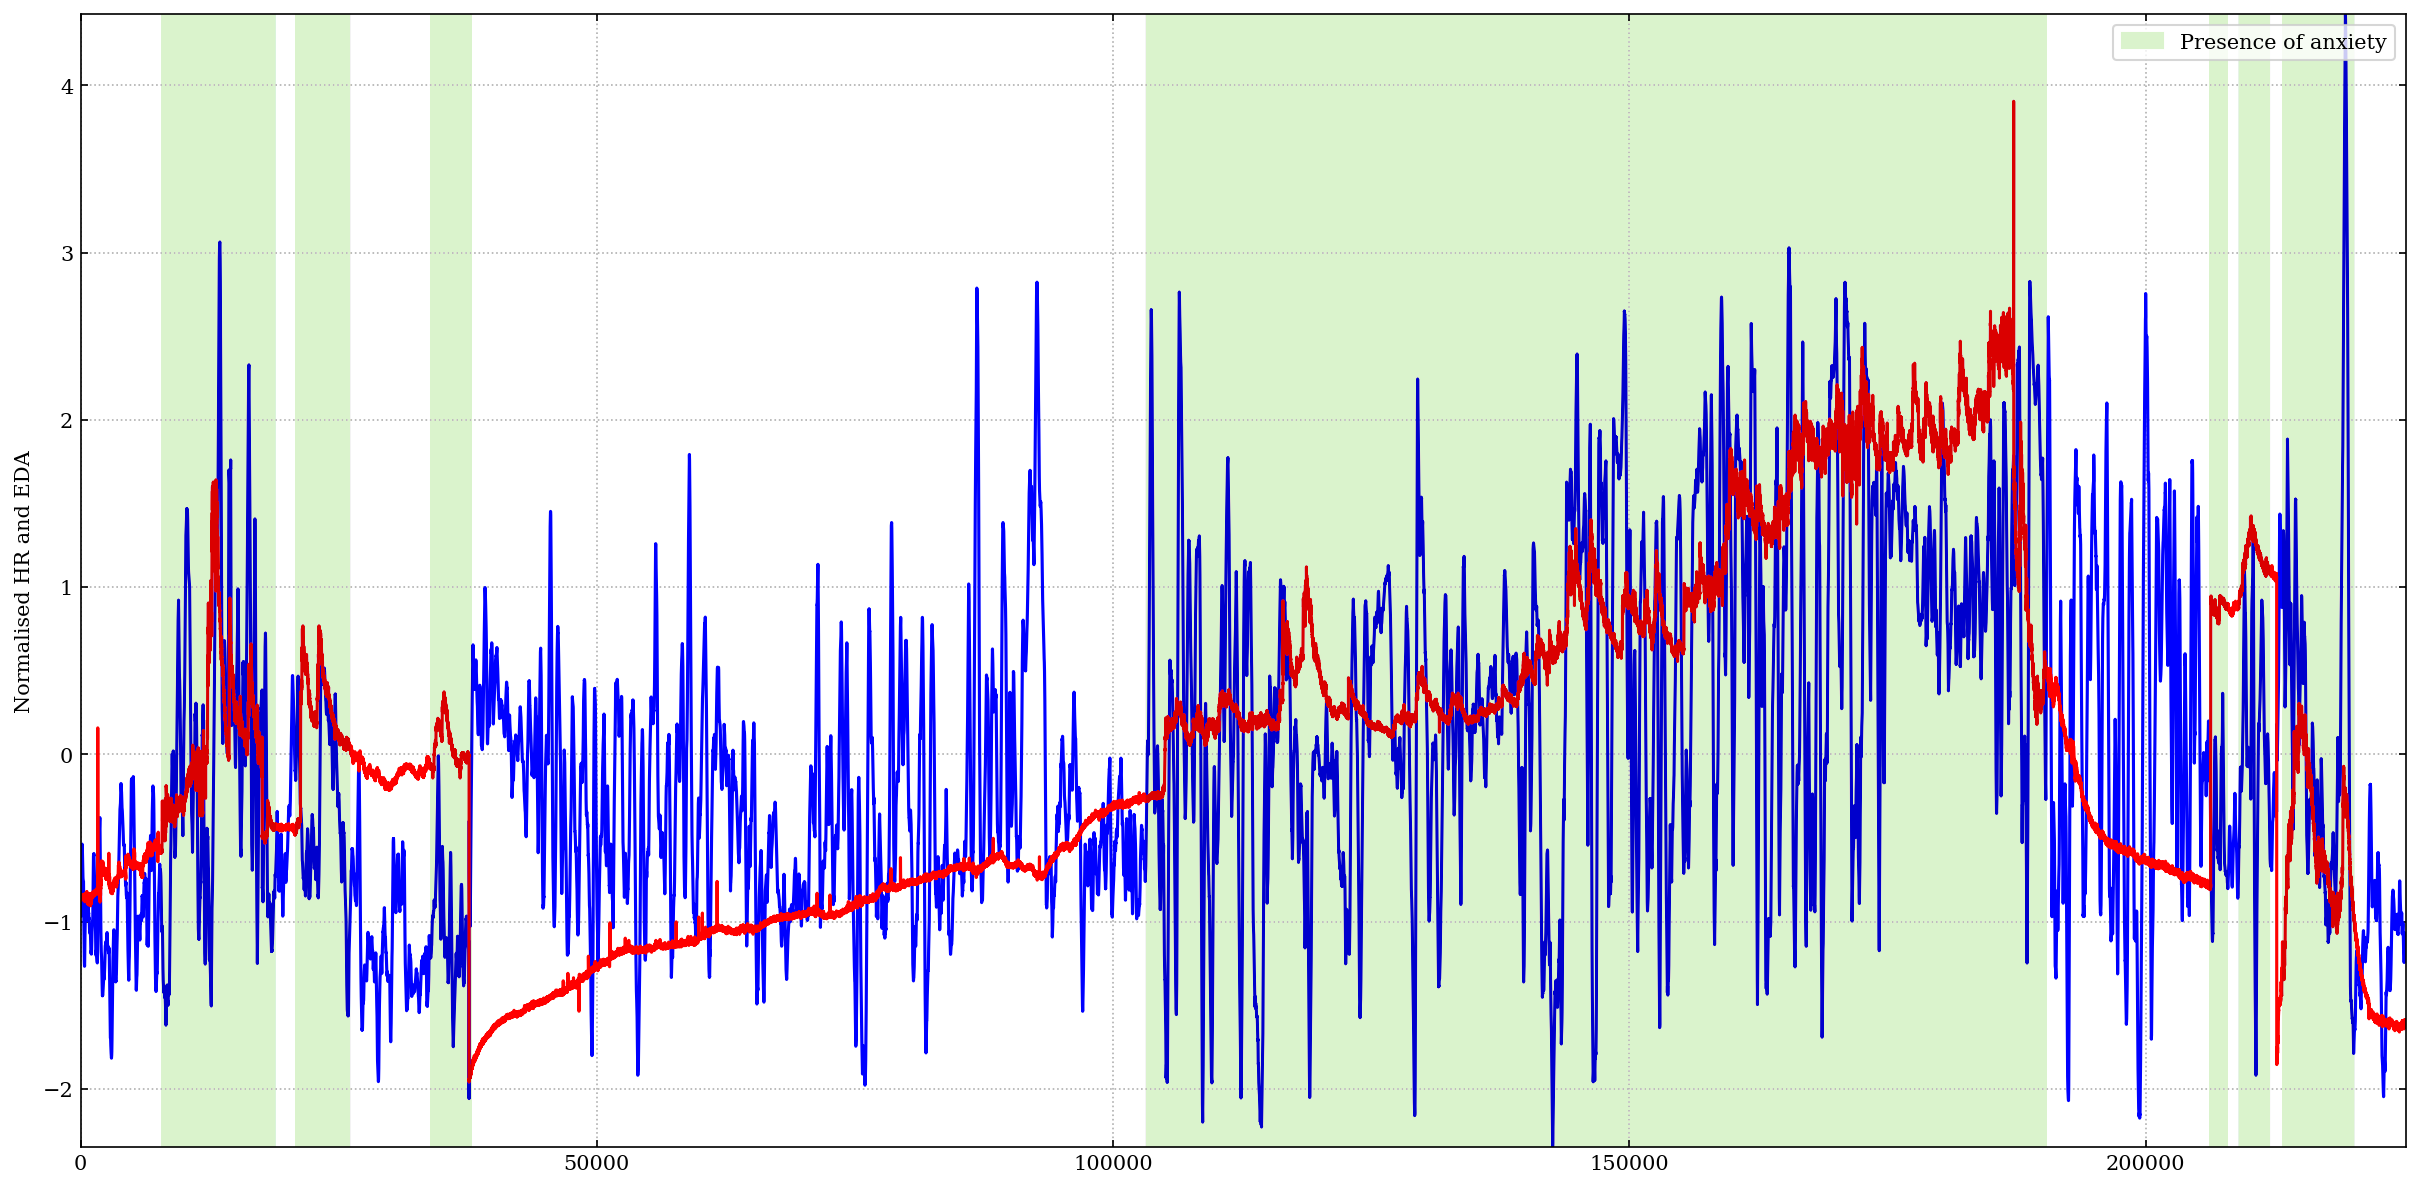

In [7]:
#Combined plot with anxiety in green

fig, axs = newfigure()
axs.set_xlim(0,225181)
axs.set_ylim(ndata['0'].min() , ndata['0'].max() +0.002)
axs.set_ylabel("Normalised HR and EDA")
#axs.set_xlabel("Anxiety and physiological reponse")
anxiety_patch = mpatches.Patch(color='#DAF3CC', label='Presence of anxiety')
plt.legend(handles=[anxiety_patch])
axs.plot(ndata['0'], 'b')
axs.plot(ndata['1'], 'r')

resultsdf['i'] = range(len(resultsdf))
pos_1 = resultsdf[resultsdf['2']==1]['i']

for x in pos_1:
     axs.axvline(resultsdf.index[x], color='#DAF3CC',linewidth=5,alpha=0.003)

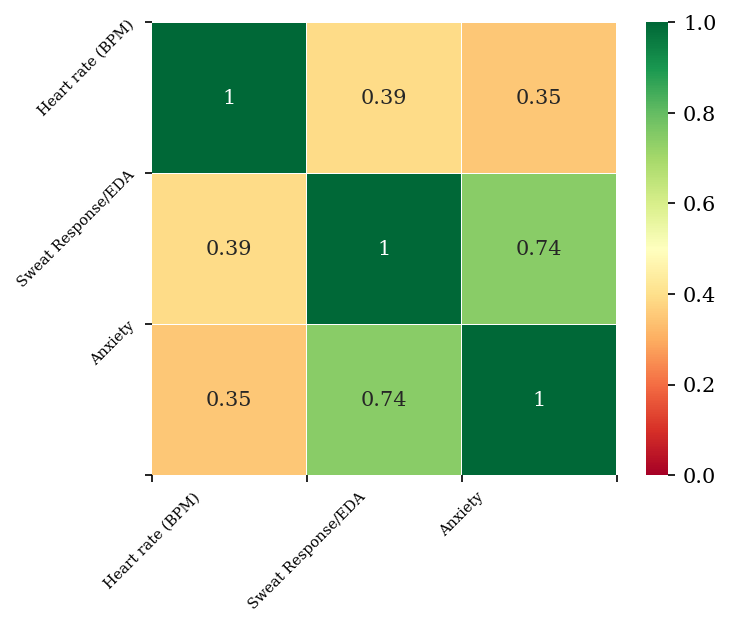

In [8]:
#Correlation Matrix

sns.heatmap(ndata.corr(), vmin=0, vmax=1, annot=True, cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(5,4)
labeldata = ['Heart rate (BPM)', 'Sweat Response/EDA', 'Anxiety']
plt.yticks(range(4),labeldata, fontsize=7, rotation = 45)
plt.xticks(range(4), labeldata, fontsize=7, rotation = 45)
plt.show()

##### 3. Normalise and split into 70% train, 30% test data

In [9]:
train,test=train_test_split(resultsdf,test_size=0.3,random_state=0,stratify=resultsdf['2'])
    
train_X=train[ndata.columns[:2]]
train_Y=train[ndata.columns[2]]
test_X=test[resultsdf.columns[:2]]
test_Y=test[resultsdf.columns[2]]
X=resultsdf[resultsdf.columns[:2]]
Y=resultsdf['2']

##### 4. Train predictive models

In [10]:
#Radial Support Vector Machines (rbf-SVM)

svmRBF=svm.SVC(kernel='rbf',C=1,gamma=0.1)
svmRBF.fit(train_X,train_Y)
prediction1=svmRBF.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.909569980016283


In [11]:
#Linear Support Vector Machine(linear-SVM)

svmSVC=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
svmSVC.fit(train_X,train_Y)
prediction2=svmSVC.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.9178743246243801


In [12]:
#Logistic

LogReg = LogisticRegression()
LogReg.fit(train_X,train_Y)
prediction3=LogReg.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

C:\Users\Ruksana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of the Logistic Regression is 0.9160979942269262


In [13]:
#Decision Tree

DecTree=DecisionTreeClassifier()
DecTree.fit(train_X,train_Y)
prediction4=DecTree.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.9672267041669751


In [14]:
#KNN

KNN=KNeighborsClassifier() 
KNN.fit(train_X,train_Y)
prediction5=KNN.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.9236918066760418


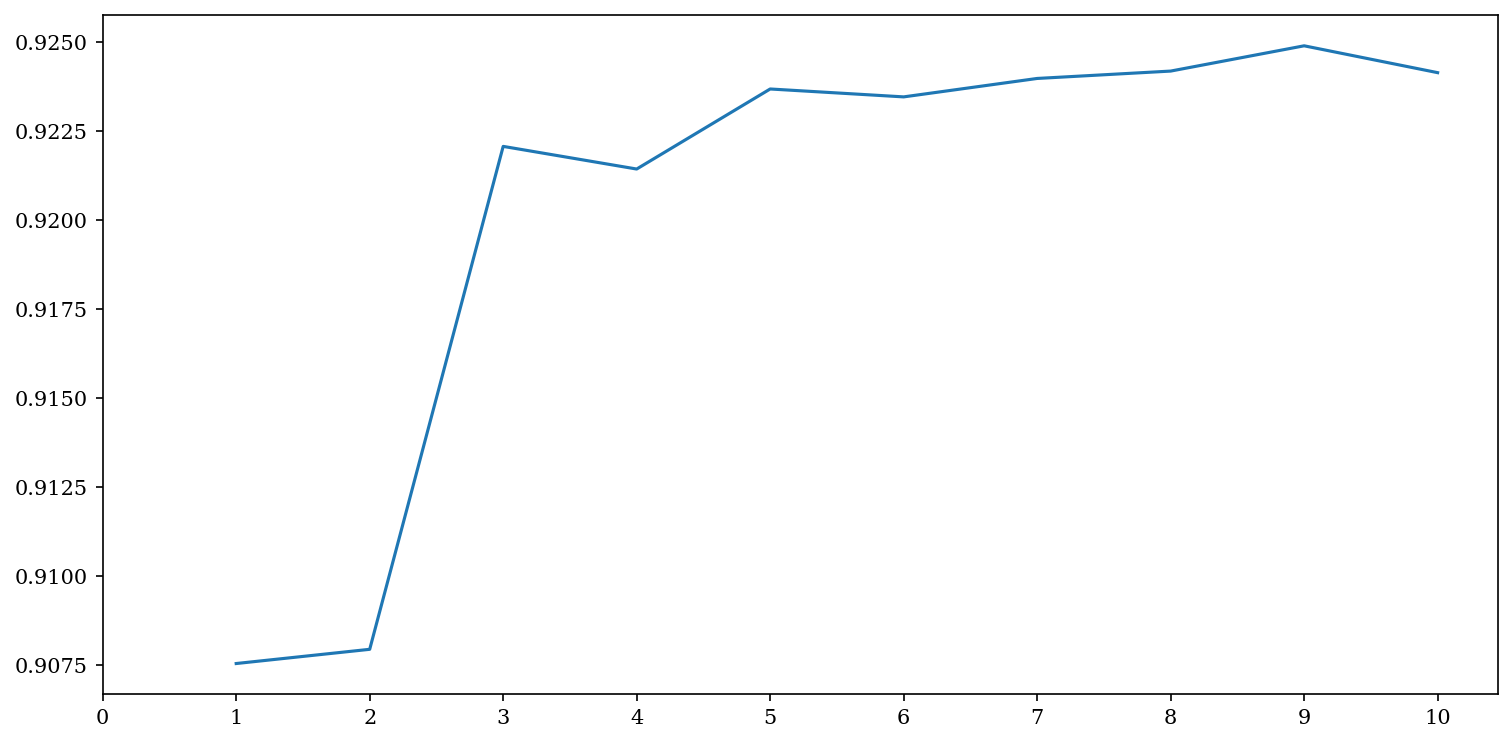

Accuracies for different values of n are: [0.907542   0.90794168 0.92207831 0.92144179 0.92369181 0.92346977
 0.92398786 0.9241951  0.92490563 0.92415069] with the max value as  0.9249056324476352


In [15]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    KNN=KNeighborsClassifier(n_neighbors=i) 
    KNN.fit(train_X,train_Y)
    prediction=KNN.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

In [16]:
#Gaussian Naive Bayes

Bayes=GaussianNB()
Bayes.fit(train_X,train_Y)
prediction6=Bayes.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.9025978832062763


In [17]:
#RandomForest

RandForest=RandomForestClassifier(n_estimators=100)
RandForest.fit(train_X,train_Y)
prediction7=RandForest.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forests is 0.9707793649618829


##### 5. Evaluate model performance

In [18]:
#7-fold

from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=7, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Radial Svm','Linear Svm','KNN','Random Forest','Decision Tree','Naive Bayes', 'Logistic Regression']
#models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),RandomForestClassifier(n_estimators=100)]
models = [svmRBF, svmSVC, KNN,  RandForest, DecTree, Bayes, LogReg]
for i in models:
    model = i
    display(model)
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

GaussianNB(priors=None, var_smoothing=1e-09)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

C:\Users\Ruksana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ruksana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ruksana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ruksana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ruksana\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

,CV Mean,Std
Radial Svm,0.885110,0.089936
Linear Svm,0.901980,0.106795
KNN,0.875513,0.080339
Random Forest,0.815380,0.103362
Decision Tree,0.808314,0.114480
Naive Bayes,0.870117,0.095462
Logistic Regression,0.908433,0.086820


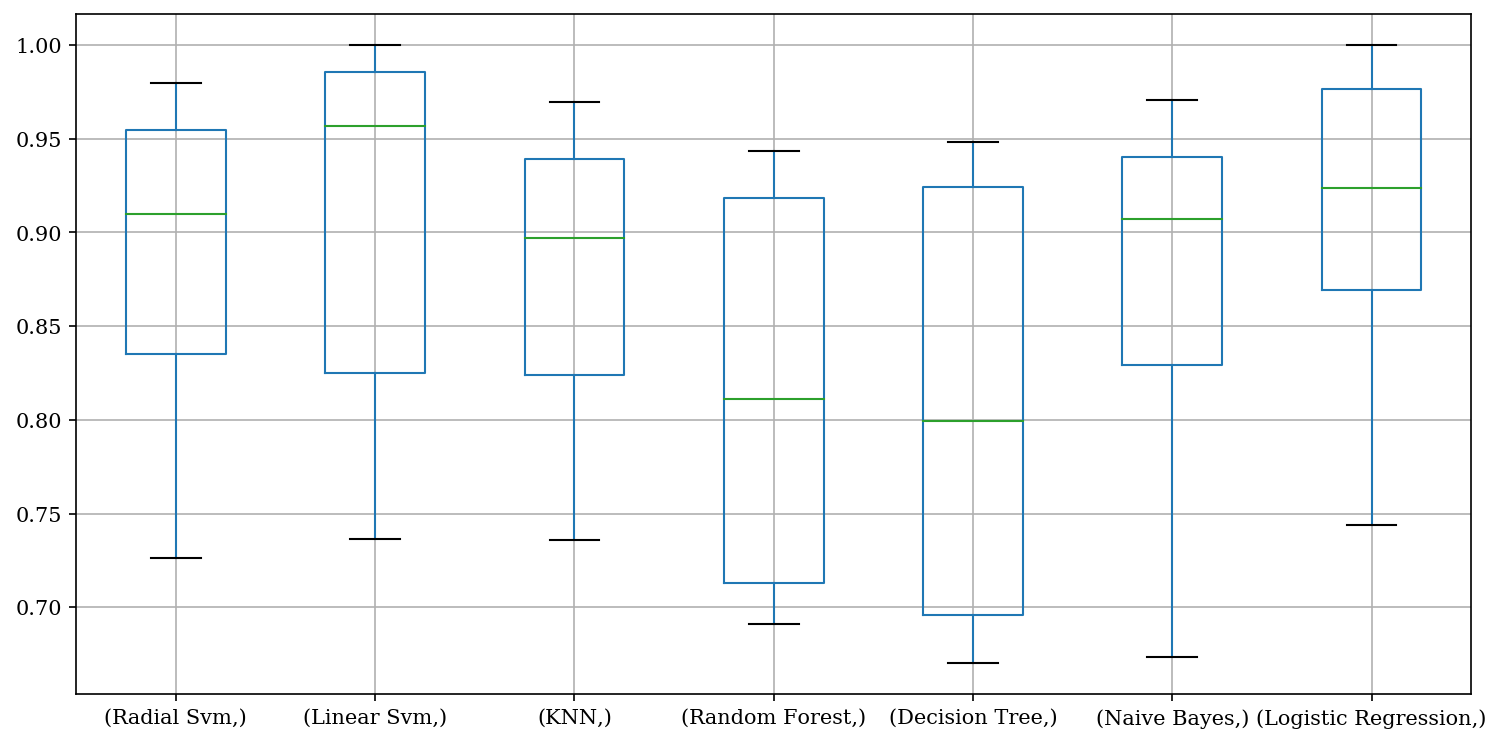

In [19]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

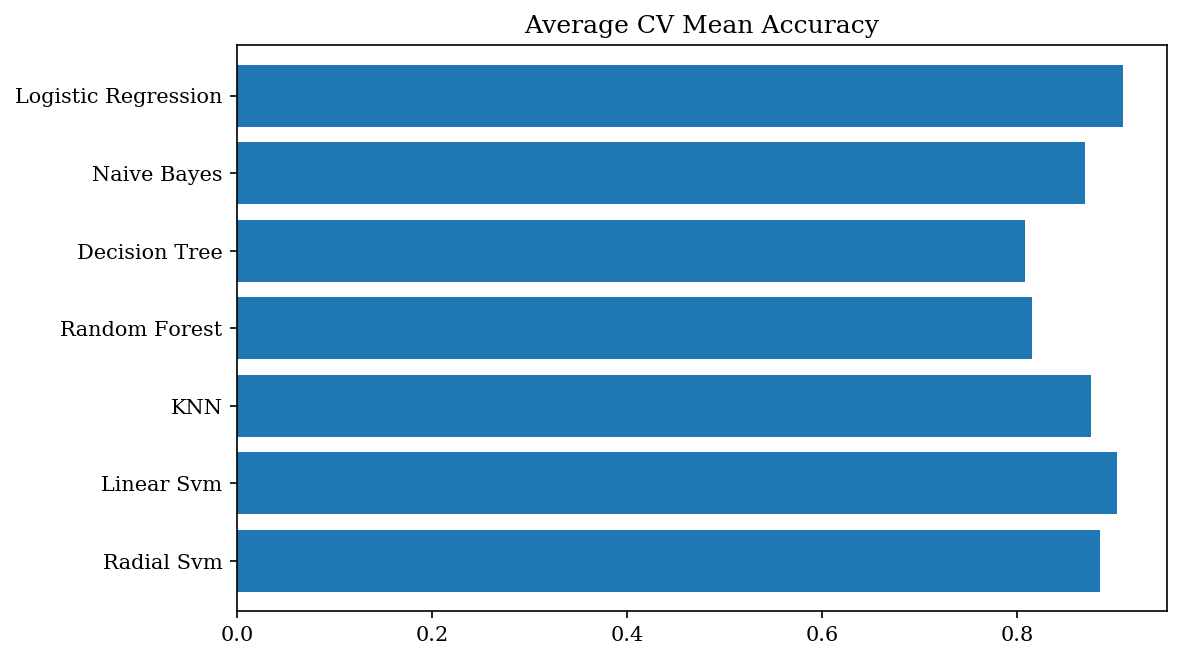

In [20]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

In [ ]:
#7 fold confusion matrices (output in 'Figures' folder)

f,ax=plt.subplots(3,3,figsize=(12,10))
akws = {'va': 'bottom','size': '12', 'color' : 'r'}
display('processing 1')
y_pred = cross_val_predict(svmRBF,X,Y,cv=7)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f', annot_kws=akws, cmap="Greens")
ttl = ax[0,0].set_title('Matrix for rbf-SVM', pad = 20)
ttl.set_position([.5, 1.05])

display('processing 2')
y_pred = cross_val_predict(svmSVC,X,Y,cv=7)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f', annot_kws=akws, cmap="Greens")
ttl = ax[0,1].set_title('Matrix for Linear-SVM', pad = 20)
ttl.set_position([.5, 1.05])

display('processing 3')
y_pred = cross_val_predict(KNN,X,Y,cv=7)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f', annot_kws=akws, cmap="Greens")
ttl = ax[0,2].set_title('Matrix for KNN', pad = 20 )
ttl.set_position([.5, 1.05])

display('processing 4')
y_pred = cross_val_predict(RandForest,X,Y,cv=7)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f', annot_kws=akws, cmap="Greens")
ttl = ax[1,0].set_title('Matrix for Random-Forests', pad = 20 )
ttl.set_position([.5, 1.05])

display('processing 5')
y_pred = cross_val_predict(DecTree,X,Y,cv=7)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f',annot_kws=akws, cmap="Greens")
ttl = ax[1,1].set_title('Matrix for Decision Tree', pad = 20 )
ttl.set_position([.5, 1.05])

display('processing 6')
y_pred = cross_val_predict(Bayes,X,Y,cv=7)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f',annot_kws=akws, cmap="Greens")
ttl = ax[1,2].set_title('Matrix for Naive Bayes', pad = 20)
ttl.set_position([.5, 1.05])

display('processing 7')
y_pred = cross_val_predict(LogReg,X,Y,cv=7)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f', annot_kws=akws, cmap="Greens")
ttl = ax[2,0].set_title('Matrix for Logistic Regression', pad = 20)
ttl.set_position([.5, 1.05])

plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.show()

'processing 1'

'processing 2'